# Convolutional Neural Network (CNN) for Facial Expression Recognition
## Alex Lauro
## APMA 4990 - Intro to Data Science Industry

Predicted emotion: Neutral 

Anger: 19.41%
Disgust: 4.48%
Fear: 18.57%
Happiness: 11.16%
Sadness: 16.46%
Surprise: 8.57%
Neutral: 21.36%


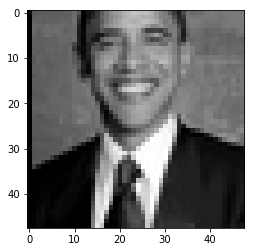

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from PIL import Image
from flask import Flask
import pickle
%matplotlib inline

# Open pickled weights and biases from trained CNN

fileObject1 = open("val_w1", 'r')
w1_val = pickle.load(fileObject1)

fileObject2 = open("val_w2", 'r')
w2_val = pickle.load(fileObject2)

fileObject3 = open("val_b1", 'r')
b1_val = pickle.load(fileObject3)

fileObject4 = open("val_b2", 'r')
b2_val = pickle.load(fileObject4)

fileObject5 = open("val_w_fc1", 'r')
w_fc1_val = pickle.load(fileObject5)

fileObject6 = open("val_w_fc2", 'r')
w_fc2_val = pickle.load(fileObject6)

fileObject7 = open("val_w_fc3", 'r')
w_fc3_val = pickle.load(fileObject7)

fileObject8 = open("val_b_fc1", 'r')
b_fc1_val = pickle.load(fileObject8)

fileObject9 = open("val_b_fc2", 'r')
b_fc2_val = pickle.load(fileObject9)

fileObject10 = open("val_b_fc3", 'r')
b_fc3_val = pickle.load(fileObject10)

fileObject11 = open("pixel_mean", 'r')
pixel_mean = pickle.load(fileObject11)

fileObject12 = open("pixel_std", 'r')
pixel_std = pickle.load(fileObject12)

# Helper methods

def resize_image(image, base_width=48):
    """
    Resizes input image to specified and adjusts height proportionally.
    
    Args:
    *image* - input image
    *base_width* - desired width of resized image
    
    Output:
    *image* - image with width *base_width* and proportional height 
    """
    
    width_percent = (base_width / float(image.size[0]))
    height_size = int((float(image.size[1]) * float(width_percent)))
    image = image.resize((base_width, height_size), Image.ANTIALIAS)
    return image

def image_to_grayscale_pixel_values(image):
    """
    Converts an image into a flattened array of pixel values. The image is 
    then converted to grayscale format so that ixel values range from 0-255 
    (0 = black, 255 = white).
    
    Args:
    *image* - input image
    
    Output:
    *flat_pixels_array* - flattened array of image pixels
    """
    
    # Convert image to 8-bit grayscale
    img = image.convert('L')  
    #img.save('/Users/Alex/Desktop/greyscale.png')
    
    width, height = img.size
    # Convert image data to a list of integers
    pixels = list(img.getdata()) 
    # Convert that to 2D list (list of lists of integers)
    pixels = [pixels[offset:offset + width] for offset in range(0, width * height, width)]
    # Convert list of lists to flattened array
    pixels_array = np.asarray(pixels)
    flat_pixels_array = pixels_array.flatten()
    return flat_pixels_array

def image_size(image):
    """
    Return image width and height
    
    Args:
    *image* - input image
    
    Output:
    *image_width* - image width
    *image_height* - image height
    """
    
    image_width, image_height = image.size
    return image_width, image_height

def crop_center(image, side_length=48):
    """
    Crops the center of an image into a square image
    
    Args:
    *image* - input image
    *side_length* - side length of cropped square image
    
    Output:
    *image_crop* - cropped image 
    """
    
    half_width = np.floor(image.size[0] / 2)
    half_height = np.floor(image.size[1] / 2)
    
    image_crop = img.crop(
        (
            half_width - (side_length / 2) - 1,
            half_height - (side_length / 2),
            half_width + (side_length / 2) - 1,
            half_height + (side_length / 2)
        )
    )
    return image_crop

def standardize_pixels(image_pixels, pixel_mean, pixel_std):
    """
    Standardizes *image_pixels* by first adjusting image norm to 100 and
    then subtracting the mean and dividing by the standard deviation of training 
    set pixel mean and pixel standard deviation
    
    Args:
    *image_pixels* - flattened array of grayscale image pixels
    *pixel_mean* - training set pixel mean
    *pixed_std* - training set pixel standard deviation
    
    Output:
    *image_pixels* - standardized flattened array of grayscale image pixels
    """
    
    #img_pixels = img_pixels - img_pixels.mean(axis=1).reshape(-1, 1)
    image_pixels = np.multiply(image_pixels, 100.0 / 255.0)
    image_pixels = np.divide(np.subtract(image_pixels, np.mean(pixel_mean)), np.mean(pixel_std))
    return image_pixels

def pre_process_image(image, pixel_mean, pixel_std):
    """
    Pre-processes image by calling resize_image, crop_center, image_to_grayscale_pixel_values,
    and standardize_pixels functions.
    
    Args:
    *image* - input image
    *pixel_mean* - training set pixel mean
    *pixed_std* - training set pixel standard deviation
    
    Output:
    *pre_processed_image_pixels* - standardized flattened array of grayscale image pixels
    """
    
    image = resize_image(image)
    image = crop_center(image)
    image_pixels = image_to_grayscale_pixel_values(image)
    image_pixels = standardize_pixels(image_pixels, pixel_mean, pixel_std)
    return image_pixels

emotion_labels = np.array([0, 1, 2, 3, 4, 5, 6])
emotion_names = np.array(['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral'])
num_emotions = emotion_labels.shape[0]

# CNN code

K = 64 # First convolutional layer output depth 
L = 128 # Second convolutional layer output depth (128 = 64 * 2)
M = 3072 # Fully connected layer 1 depth (3072 = 128 * 24)

def CNN(img_pixels):
    # Image placeholder
    x = tf.placeholder('float', shape=[None, img_pixels.shape[0]])
    image = tf.reshape(x, [-1, np.sqrt(img_pixels.shape[0]).astype(np.uint8), np.sqrt(img_pixels.shape[0]).astype(np.uint8), 1])

    # First convolutional layer with depth 64 and 5x5 filter size
    w1 = tf.Variable(tf.truncated_normal([5, 5, 1, K], stddev=1e-4))
    b1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))

    conv1 = tf.nn.relu(tf.nn.conv2d(image, w1, strides=[1, 1, 1, 1], padding="SAME") + b1)
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)

    # Second convolutional layer with depth 128 and 5x5 filter size
    w2 = tf.Variable(tf.truncated_normal([5, 5, 64, L], stddev=1e-4))
    b2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))

    conv2 = tf.nn.relu(tf.nn.conv2d(norm1, w2, strides=[1, 1, 1, 1], padding="SAME") + b2)
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
    pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Fully connected layer 1
    w_fc1 = tf.Variable(tf.truncated_normal([12 * 12 * L, M], stddev=0.04))
    b_fc1 = tf.Variable(tf.constant(0.0, tf.float32, [M]))

    pool2_loc = tf.reshape(pool2, [-1, 12 * 12 * L])
    h_fc1 = tf.nn.relu(tf.matmul(pool2_loc, w_fc1) + b_fc1)
    
    # Fully connected layer 2
    w_fc2 = tf.Variable(tf.truncated_normal([3072, 1536], stddev=0.04))
    b_fc2 = tf.Variable(tf.constant(0.0, tf.float32, [1536]))

    h_fc2_reshape = tf.reshape(h_fc1, [-1, 3072])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc2_reshape, w_fc2) + b_fc2)

    # Dropout
    keep_prob = tf.placeholder('float')
    h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

    # Final fully connected layer feeding into softmax classifier
    w_fc3 = tf.Variable(tf.truncated_normal([1536, num_emotions], stddev=0.04))
    b_fc3 = tf.Variable(tf.constant(0.0, tf.float32, [num_emotions]))

    y = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)
    
    # Prediction function
    prediction = tf.argmax(y, 1)
    probabilities = y
    
    # Start TensorFlow session and assign learned weights and biases to model
    init = tf.initialize_all_variables()

    w1_op = w1.assign(w1_val)
    b1_op = b1.assign(b1_val)
    w2_op = w2.assign(w2_val)
    b2_op = b2.assign(b2_val)
    w_fc1_op = w_fc1.assign(w_fc1_val)
    b_fc1_op = b_fc1.assign(b_fc1_val)
    w_fc2_op = w_fc2.assign(w_fc2_val)
    b_fc2_op = b_fc2.assign(b_fc2_val)
    w_fc3_op = w_fc3.assign(w_fc3_val)
    b_fc3_op = b_fc3.assign(b_fc3_val)

    sess = tf.InteractiveSession()
    sess.run([w1_op, b1_op, w2_op, b2_op, w_fc1_op, b_fc1_op, w_fc2_op, b_fc2_op, w_fc3_op, b_fc3_op])
    
    # Run CNN model on test image
    predicted_label = np.zeros(1)
    predicted_prob = np.zeros(num_emotions)

    image = np.array(img_pixels).reshape(1, img_pixels.shape[0])
    
    # Find predicted emotion label and probability distribution across emotion labels
    predicted_label = prediction.eval(feed_dict={x: image, keep_prob: 1.0})
    probabilities = probabilities.eval(feed_dict={x: image, keep_prob: 1.0})
    
    return predicted_label, probabilities

file_path = "/Users/Alex/Desktop/obama_tall.jpeg"
img = Image.open(file_path)

# Resize image based on given base width
img = resize_image(img)

# Crop center of image
img = crop_center(img)

# Find image height and width
img_width, img_height = image_size(img)

# Convert image to flattened array of grayscale pixel values
img_pixels = image_to_grayscale_pixel_values(img)

# Standardize image pixels based on mean and standard deviations of pixels of training images
img_pixels = standardize_pixels(img_pixels, pixel_mean, pixel_std)

show_image = img_pixels.reshape(48,48)
plt.imshow(show_image, cmap='gray')

predicted_label, probabilities = CNN(img_pixels)
print "Predicted emotion: %s \n" % emotion_names[predicted_label][0]

for i in range(num_emotions):
    print "%s: %.2f%%" % (emotion_names[i], probabilities[0][i] * 100.0)

